In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!unzip "faces.zip" -d .

In [ ]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="faces/training/")

In [ ]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

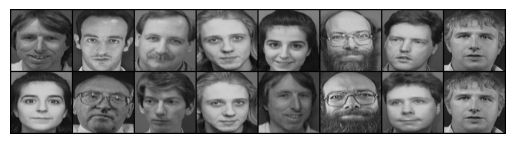

[1. 1. 1. 0. 1. 0. 1. 0.]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

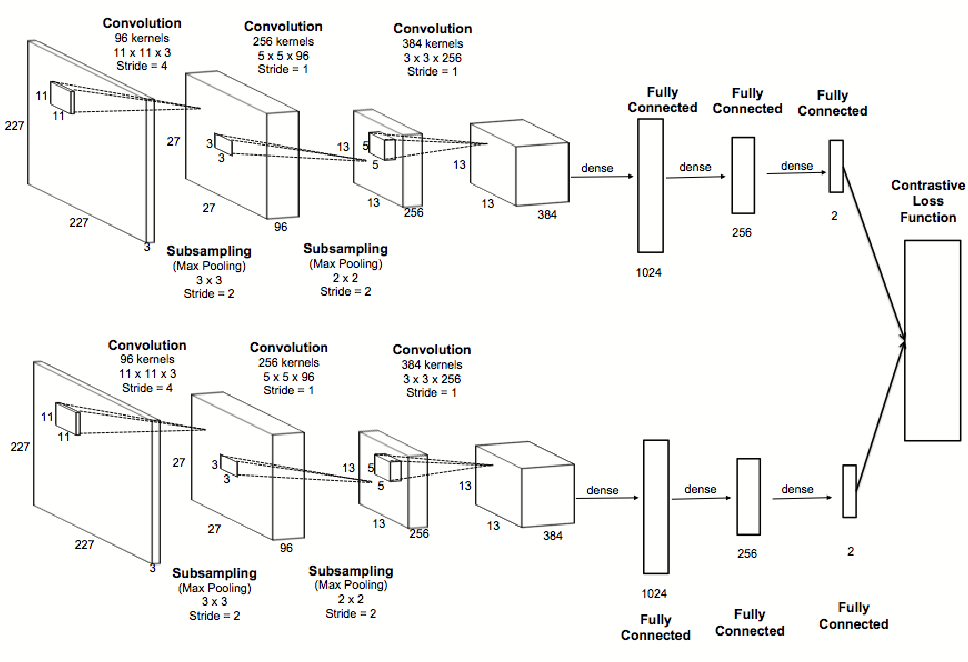

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

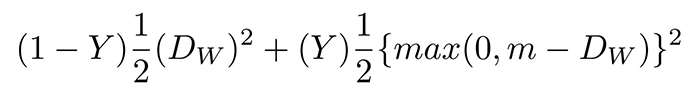

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 2.372835636138916

Epoch number 1
 Current loss 0.9316825866699219

Epoch number 2
 Current loss 0.8503172993659973

Epoch number 3
 Current loss 1.0130295753479004

Epoch number 4
 Current loss 0.846377968788147

Epoch number 5
 Current loss 0.7389708757400513

Epoch number 6
 Current loss 0.6129536628723145

Epoch number 7
 Current loss 0.40640586614608765

Epoch number 8
 Current loss 0.5783063769340515

Epoch number 9
 Current loss 0.5811063051223755

Epoch number 10
 Current loss 0.6214967966079712

Epoch number 11
 Current loss 0.43372294306755066

Epoch number 12
 Current loss 0.5021368861198425

Epoch number 13
 Current loss 0.3881884813308716

Epoch number 14
 Current loss 0.4979984760284424

Epoch number 15
 Current loss 0.3867214024066925

Epoch number 16
 Current loss 0.42777878046035767

Epoch number 17
 Current loss 0.4784904718399048

Epoch number 18
 Current loss 0.3889566659927368

Epoch number 19
 Current loss 0.37198004126548767

Epoch nu

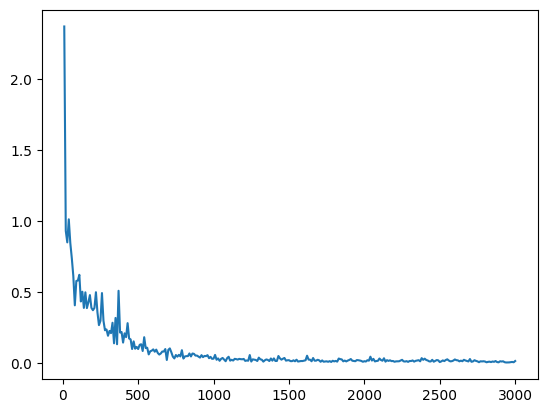

In [ ]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(300):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

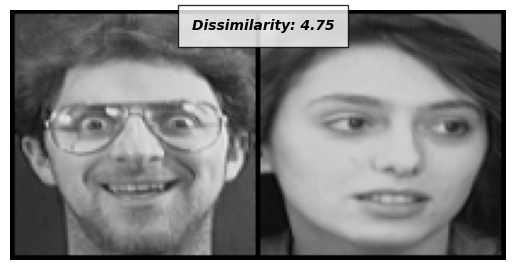

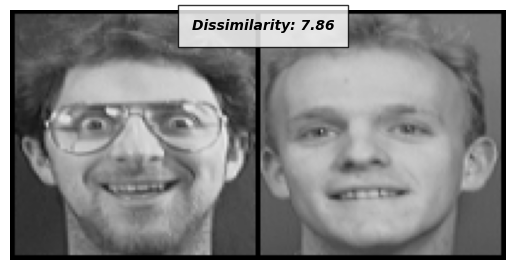

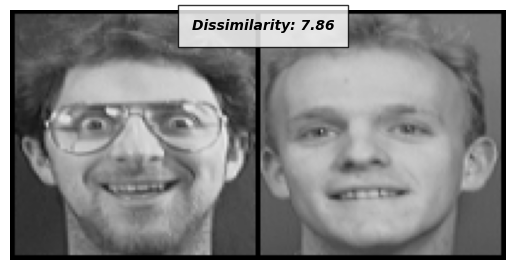

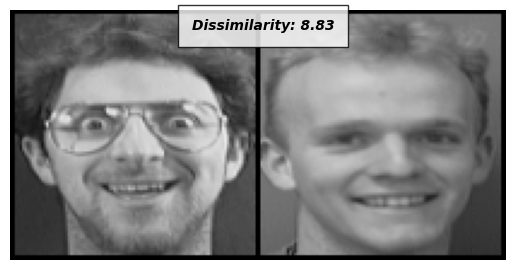

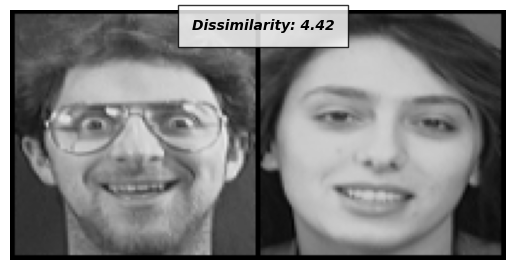

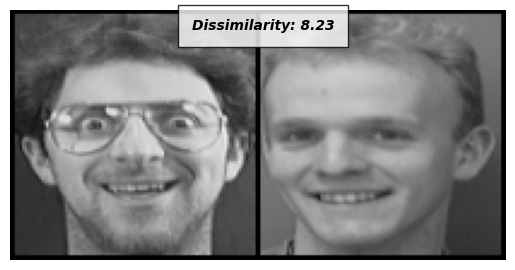

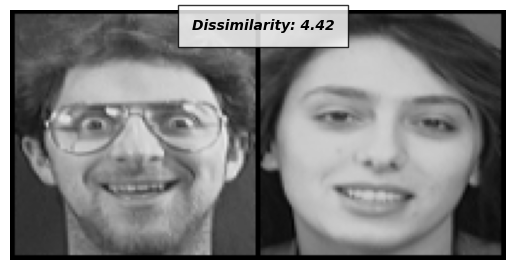

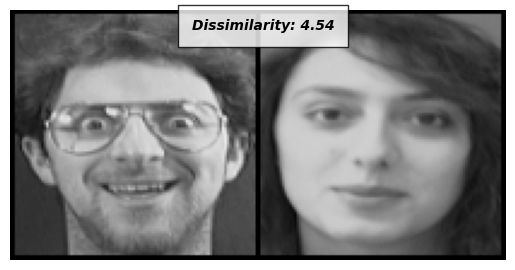

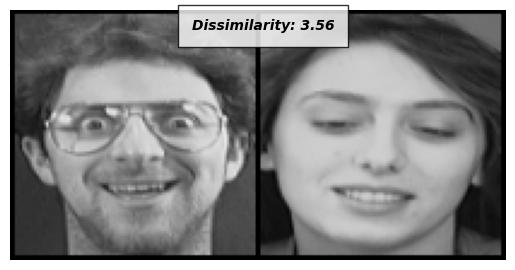

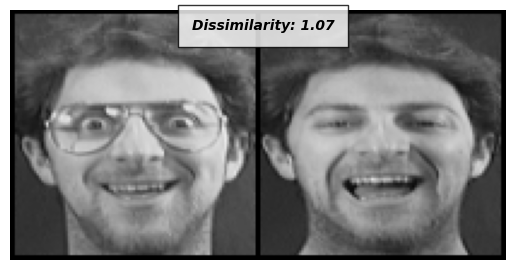

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [ ]:
class SiameseTestDataset(Dataset):
    def __init__(self, imageFolderDataset, n_way, k_shot, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.n_way = n_way  # Number of classes to sample
        self.k_shot = k_shot  # Number of examples per class to sample
        self.transform = transform

    def __getitem__(self, index):
        # Select one image randomly from the test set
        test_img_tuple = random.choice(self.imageFolderDataset.imgs)
        test_class_original = test_img_tuple[1]

        support_set = []
        target_set = []
        sampled_classes = []
        test_class = test_class_original
        for _ in range(self.n_way):
            sampled_classes.append(test_class)
            class_imgs = [img_tuple for img_tuple in self.imageFolderDataset.imgs if img_tuple[1] == test_class]
            support_imgs = random.sample(class_imgs, self.k_shot)  # Sample k_shot images from the same class

            for support_img_tuple in support_imgs:
                support_img = Image.open(support_img_tuple[0])
                support_img = support_img.convert("L")

                if self.transform is not None:
                    support_img = self.transform(support_img)

                support_set.append(support_img)
                target_set.append(int(support_img_tuple[1] != test_class_original))  # 1 if different class, 0 otherwise

            # Select a different class for the next iteration
            available_classes = [img_tuple[1] for img_tuple in self.imageFolderDataset.imgs if img_tuple[1] not in sampled_classes]

            if len(available_classes) == 0:
                break

            test_class = random.choice(available_classes)

        test_img = Image.open(test_img_tuple[0])
        test_img = test_img.convert("L")

        if self.transform is not None:
            test_img = self.transform(test_img)

        return test_img, support_set, torch.from_numpy(np.array(target_set, dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)


In [ ]:
folder_dataset_test = datasets.ImageFolder(root="faces/testing/")
siamese_dataset = SiameseTestDataset(imageFolderDataset=folder_dataset_test, n_way=5,k_shot=1, transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=False)

In [ ]:
test_dataloader

In [ ]:
dataiter = iter(test_dataloader)
data = next(dataiter)


## example test sample

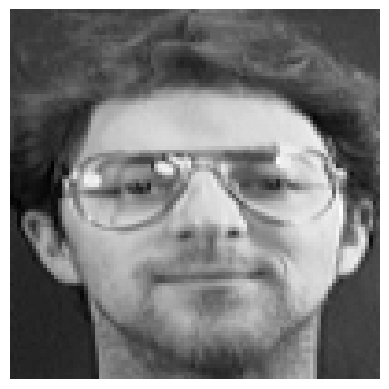

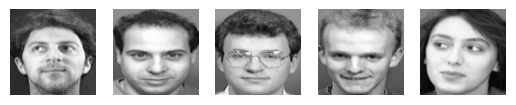

tensor([[0., 1., 1., 1., 1.]])


In [ ]:
import matplotlib.pyplot as plt


def print_image(image_tensor):
    image = image_tensor.squeeze().cpu().numpy()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

print_image(data[0])


def show_images_side_by_side(image_tensors):
    fig, axs = plt.subplots(1, len(image_tensors))

    for i, image_tensor in enumerate(image_tensors):
        image = image_tensor.squeeze().numpy()  # Convert tensor to numpy array
        axs[i].imshow(image, cmap='gray')
        axs[i].axis('off')

    plt.show()
show_images_side_by_side(data[1])
print(data[2])

In [ ]:
test_images, support_set, targets = data

similarities = []

# Calculate the similarity scores between the test image and each support image individually
for i in range(len(support_set)):
    # Pass the test image and individual support image to your trained Siamese model


    # Calculate the similarity score between the test output and support output using your similarity function
    output1, output2 = net(test_images.cuda(), support_set[i].cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)

    similarities.append(euclidean_distance)
similarities

[tensor([0.8091], device='cuda:0', grad_fn=<NormBackward1>),
 tensor([3.3917], device='cuda:0', grad_fn=<NormBackward1>),
 tensor([3.0338], device='cuda:0', grad_fn=<NormBackward1>),
 tensor([9.2340], device='cuda:0', grad_fn=<NormBackward1>),
 tensor([5.3875], device='cuda:0', grad_fn=<NormBackward1>)]

test set


In [ ]:
net.eval()
correct_predictions = 0
total_predictions = 0

# Iterate over the test dataloader
for batch in test_dataloader:

    test_images, support_set, targets = batch

    similarities = []

    # Calculate the similarity scores between the test image and each support image individually
    for i in range(len(support_set)):
        # Pass the test image and individual support image to your trained Siamese model


        # Calculate the similarity score between the test output and support output using your similarity function
        output1, output2 = net(test_images.cuda(), support_set[i].cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)

        similarities.append(euclidean_distance)

    # Find the index of the lowest similarity score
    lowest_similarity_index = similarities.index(min(similarities))

    # Compare the target at the lowest similarity index with 0 (matching pair)
    if targets[0][lowest_similarity_index] == 0:
        correct_predictions += 1

    total_predictions += 1

# Calculate the accuracy
accuracy = correct_predictions / total_predictions
print("Accuracy: {:.2%}".format(accuracy))
print(total_predictions)

Accuracy: 94.00%
50
